# Workflow to extract Landsat Image Information developed by Redwan

**I developed this  workflow to identify which landsat image should be downloaded according to the weather station data for peak summer temperature for each study period. The process to download landsat image from usgs website according to our customized need is often time-consuming and difficult. To reduce the workload of downloading and filtering customized image according to our need this code helps to extract landsat image information such as number of image captured during specified time range, Image ID, band names, capturing date, cloud coverage and the footprint of the image over the area of interest.** 

In [2]:
!pip install earthengine-api


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import ee
ee.Authenticate()
ee.Initialize()


Enter verification code: 4/1AfJohXkWRgSfqromOiYvKVvKgLzPIyR3DpzN7wJv-ZEMhKablxSg1tukwBY

Successfully saved authorization token.


In [1]:
import datetime
import ee
import folium

# Initialize Earth Engine
ee.Initialize()

# Define a function to get image information as a dictionary
def get_image_info(image):
    image_id = image.get('system:index').getInfo()
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    band_names = image.bandNames().getInfo()
    cloud_cover = image.get('CLOUD_COVER').getInfo()
    
    return {
        'Image ID': image_id,
        'Capture Date': date,
        'Band Names': band_names,
        'Cloud Cover (%)': cloud_cover,
        'Image': image  # Store the Earth Engine image object
    }

# Define the bounding box coordinates
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Convert the bounding box to an Earth Engine Geometry object
geometry = ee.Geometry.Rectangle(bounding_box)

# Define the date range for your search
date_start = datetime.datetime(2000, 8, 1)
date_end = datetime.datetime(2000, 8, 30)

# Define the cloud cover threshold (adjust as needed)
cloud_cover_threshold = 20

# Filter the Landsat collection based on the bounding box, date range, and cloud cover threshold
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")) \
    .merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")) \
    .filterBounds(geometry) \
    .filterDate(date_start, date_end) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_cover_threshold)

# Get the image information and store it in a list of dictionaries
image_info_list = []
num_images = landsat_collection.size().getInfo()
image_list = landsat_collection.toList(num_images)

for i in range(num_images):
    image = ee.Image(image_list.get(i))
    image_info = get_image_info(image)
    image_info_list.append(image_info)

# Create a pandas DataFrame from the list of dictionaries
import pandas as pd
df = pd.DataFrame(image_info_list)

# Display the DataFrame
print(df)

# Create a color palette for different image IDs
import random
import matplotlib.colors as colors
image_ids = df['Image ID'].unique()
num_colors = len(image_ids)
color_palette = [colors.to_hex([random.random(), random.random(), random.random()]) for _ in range(num_colors)]

# Visualize the captured images on the map
# Get the center of the bounding box for map centering
center = [sum(bounding_box[1::2])/2, sum(bounding_box[::2])/2]

# Create a folium map
m = folium.Map(location=center, zoom_start=10)

# Add image footprints to the map with corresponding colors
for image_info in image_info_list:
    image = image_info['Image']
    date = image_info['Capture Date']
    image_id = image_info['Image ID']
    color = color_palette[list(image_ids).index(image_id)]
    footprint = image.geometry()
    
    # Create a GeoJSON FeatureCollection with the footprint and assigned color
    feature_collection = ee.FeatureCollection([ee.Feature(footprint, {'style': {'color': color}})])
    
    # Add the FeatureCollection to the map
    folium.GeoJson(
        data=feature_collection.getInfo(),
        name=f"{image_id} - {date}",
        style_function=lambda x: {'color': x['properties']['style']['color'], 'fillOpacity': 0.5, 'weight': 1}
    ).add_to(m)

# Create a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: auto; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Legend</b> <br>"""

for idx, image_id in enumerate(image_ids):
    color = color_palette[idx]
    legend_html += f'<i style="background:{color}; width: 12px; height: 12px; display: inline-block;"></i>&nbsp;{image_id}<br>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(m)


RefreshError: ('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})

# 1.  Extracting Landsat Image capturing dates and cloud coverage

In [25]:
import datetime
import ee

# Initialize Earth Engine
ee.Initialize()

# Define a function to print image information
def print_image_info(image):
    image_id = image.get('system:index').getInfo()
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    band_names = image.bandNames().getInfo()
    cloud_cover = image.get('CLOUD_COVER').getInfo()  # Add this line to get cloud cover info
    print(f"Image ID: {image_id}, Capture Date: {date}")
    #print("Band Names:", band_names)
    print("Cloud Cover: {:.2f}%".format(cloud_cover))  # Print cloud cover as a percentage

# Define the bounding box coordinates
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Convert the bounding box to an Earth Engine Geometry object
geometry = ee.Geometry.Rectangle(bounding_box)

# Define the date range for your search
date_start = datetime.datetime(2015, 7, 1)
date_end = datetime.datetime(2015, 9, 30)

# Define the cloud cover threshold (adjust as needed)
cloud_cover_threshold = 20  # Images with cloud cover less than 30% will be included

# Filter the Landsat collection based on the bounding box, date range, and cloud cover threshold
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")) \
    .merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")) \
    .filterBounds(geometry) \
    .filterDate(date_start, date_end) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_cover_threshold)  # Filter based on cloud cover

# Get the number of images in the collection
num_images = landsat_collection.size().getInfo()

# Print the number of images
print(f"Number of Landsat images found: {num_images}")

# Get the list of image IDs and capture dates
image_list = landsat_collection.toList(num_images)
for i in range(num_images):
    image = ee.Image(image_list.get(i))
    print_image_info(image)


Number of Landsat images found: 5
Image ID: 1_1_LC08_022031_20150802, Capture Date: 2015-08-02
Cloud Cover: 2.32%
Image ID: 1_1_LC08_023031_20150926, Capture Date: 2015-09-26
Cloud Cover: 3.06%
Image ID: 2_LE07_023030_20150902, Capture Date: 2015-09-02
Cloud Cover: 5.00%
Image ID: 2_LE07_023031_20150801, Capture Date: 2015-08-01
Cloud Cover: 15.00%
Image ID: 2_LE07_023031_20150902, Capture Date: 2015-09-02
Cloud Cover: 18.00%


# 2. Extracting Band Information in table 

In [8]:
import datetime
import pandas as pd

# Define a function to get image information as a dictionary
def get_image_info(image):
    image_id = image.get('system:index').getInfo()
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    band_names = image.bandNames().getInfo()
    cloud_cover = image.get('CLOUD_COVER').getInfo()
    
    return {
        'Image ID': image_id,
        'Capture Date': date,
        'Band Names': band_names,
        'Cloud Cover (%)': cloud_cover
    }

# Define the bounding box coordinates
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Convert the bounding box to an Earth Engine Geometry object
geometry = ee.Geometry.Rectangle(bounding_box)

# Define the date range for your search
date_start = datetime.datetime(2017, 7, 1)
date_end = datetime.datetime(2017, 7, 31)

# Define the cloud cover threshold (adjust as needed)
cloud_cover_threshold = 20

# Filter the Landsat collection based on the bounding box, date range, and cloud cover threshold
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")) \
    .merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")) \
    .filterBounds(geometry) \
    .filterDate(date_start, date_end) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_cover_threshold)

# Get the image information and store it in a list of dictionaries
image_info_list = []
num_images = landsat_collection.size().getInfo()
image_list = landsat_collection.toList(num_images)

for i in range(num_images):
    image = ee.Image(image_list.get(i))
    image_info = get_image_info(image)
    image_info_list.append(image_info)

# Create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(image_info_list)

# Display the DataFrame
print(df)


                   Image ID Capture Date  \
0  1_1_LC08_022031_20170706   2017-07-06   
1  1_1_LC08_023030_20170729   2017-07-29   
2  1_1_LC08_023031_20170729   2017-07-29   
3    2_LE07_022031_20170730   2017-07-30   

                                          Band Names  Cloud Cover (%)  
0  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...             9.68  
1  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...             2.95  
2  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...             7.95  
3  [B1, B2, B3, B4, B5, B6, B7, sr_atmos_opacity,...             9.00  


# 3. Data Visualization with relevant information

# **a. Extracting 2005 Weather station data to identify peak temperature date in that particular year**

**Example: Extracting data for the highest temperature date for the year 2000 according to NOAA data**

In [9]:
import datetime
import ee
import folium

# Initialize Earth Engine
ee.Initialize()

# Define a function to get image information as a dictionary
def get_image_info(image):
    image_id = image.get('system:index').getInfo()
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    band_names = image.bandNames().getInfo()
    cloud_cover = image.get('CLOUD_COVER').getInfo()
    
    return {
        'Image ID': image_id,
        'Capture Date': date,
        'Band Names': band_names,
        'Cloud Cover (%)': cloud_cover,
        'Image': image  # Store the Earth Engine image object
    }

# Define the bounding box coordinates
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Convert the bounding box to an Earth Engine Geometry object
geometry = ee.Geometry.Rectangle(bounding_box)

# Define the date range for your search
date_start = datetime.datetime(2022, 8, 15)
date_end = datetime.datetime(2022, 9, 15)

# Define the cloud cover threshold (adjust as needed)
cloud_cover_threshold = 30

# Filter the Landsat collection based on the bounding box, date range, and cloud cover threshold
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")) \
    .merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")) \
    .filterBounds(geometry) \
    .filterDate(date_start, date_end) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_cover_threshold)

# Get the image information and store it in a list of dictionaries
image_info_list = []
num_images = landsat_collection.size().getInfo()
image_list = landsat_collection.toList(num_images)

for i in range(num_images):
    image = ee.Image(image_list.get(i))
    image_info = get_image_info(image)
    image_info_list.append(image_info)

# Get the number of images in the collection
num_images = landsat_collection.size().getInfo()

# Print the number of images
print(f"Number of Landsat images found: {num_images}")

# Create a pandas DataFrame from the list of dictionaries
import pandas as pd
df = pd.DataFrame(image_info_list)

# Display the DataFrame
print(df)

# Create a color palette for different image IDs
import random
import matplotlib.colors as colors
image_ids = df['Image ID'].unique()
num_colors = len(image_ids)
color_palette = [colors.to_hex([random.random(), random.random(), random.random()]) for _ in range(num_colors)]

# Visualize the captured images on the map
# Get the center of the bounding box for map centering
center = [sum(bounding_box[1::2])/2, sum(bounding_box[::2])/2]

# Create a folium map
m = folium.Map(location=center, zoom_start=10)

# Add image footprints to the map with corresponding colors
for image_info in image_info_list:
    image = image_info['Image']
    date = image_info['Capture Date']
    image_id = image_info['Image ID']
    color = color_palette[list(image_ids).index(image_id)]
    footprint = image.geometry()
    
    # Create a GeoJSON FeatureCollection with the footprint and assigned color
    feature_collection = ee.FeatureCollection([ee.Feature(footprint, {'style': {'color': color}})])
    
    # Add the FeatureCollection to the map
    folium.GeoJson(
        data=feature_collection.getInfo(),
        name=f"{image_id} - {date}",
        style_function=lambda x: {'color': x['properties']['style']['color'], 'fillOpacity': 0.5, 'weight': 1}
    ).add_to(m)

# Create a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: auto; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Legend</b> <br>"""

for idx, image_id in enumerate(image_ids):
    color = color_palette[idx]
    legend_html += f'<i style="background:{color}; width: 12px; height: 12px; display: inline-block;"></i>&nbsp;{image_id}<br>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(m)


Number of Landsat images found: 0
Empty DataFrame
Columns: []
Index: []


KeyError: 'Image ID'

# **b. Extracting 2005 Weather station data to identify peak temperature date in that particular year**

          date datatype            station attributes  value  moving_avg
0   2015-01-01     TMAX  GHCND:USW00094846   ,,W,2400    0.0         NaN
1   2015-01-02     TMAX  GHCND:USW00094846   ,,W,2400    1.1         NaN
2   2015-01-03     TMAX  GHCND:USW00094846   ,,W,2400    1.1       -2.30
3   2015-01-04     TMAX  GHCND:USW00094846   ,,W,2400    0.6       -4.72
4   2015-01-05     TMAX  GHCND:USW00094846   ,,W,2400  -14.3       -7.80
..         ...      ...                ...        ...    ...         ...
360 2015-12-27     TMAX  GHCND:USW00094846   ,,W,2400    4.4        4.90
361 2015-12-28     TMAX  GHCND:USW00094846   ,,W,2400    3.9        3.24
362 2015-12-29     TMAX  GHCND:USW00094846   ,,W,2400    3.9        1.70
363 2015-12-30     TMAX  GHCND:USW00094846   ,,W,2400   -1.6         NaN
364 2015-12-31     TMAX  GHCND:USW00094846   ,,W,2400   -2.1         NaN

[365 rows x 6 columns]


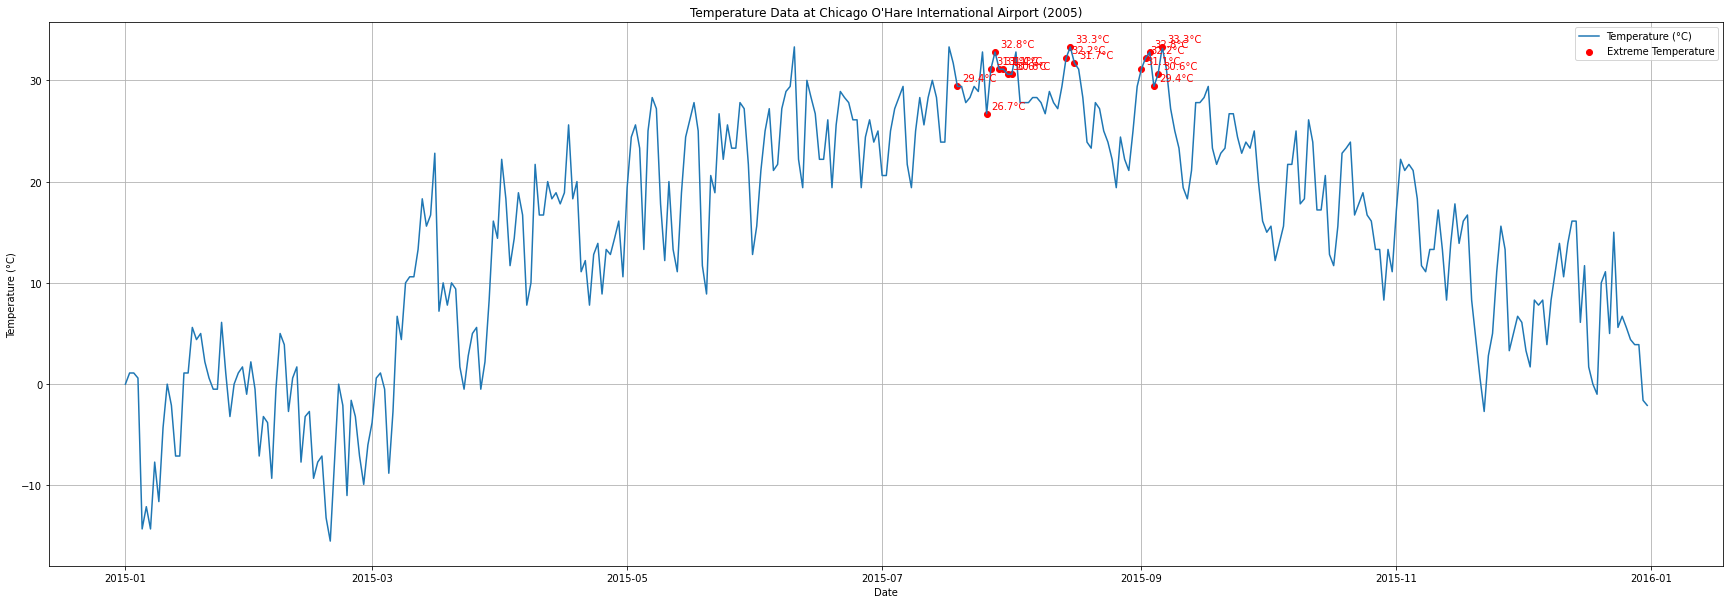

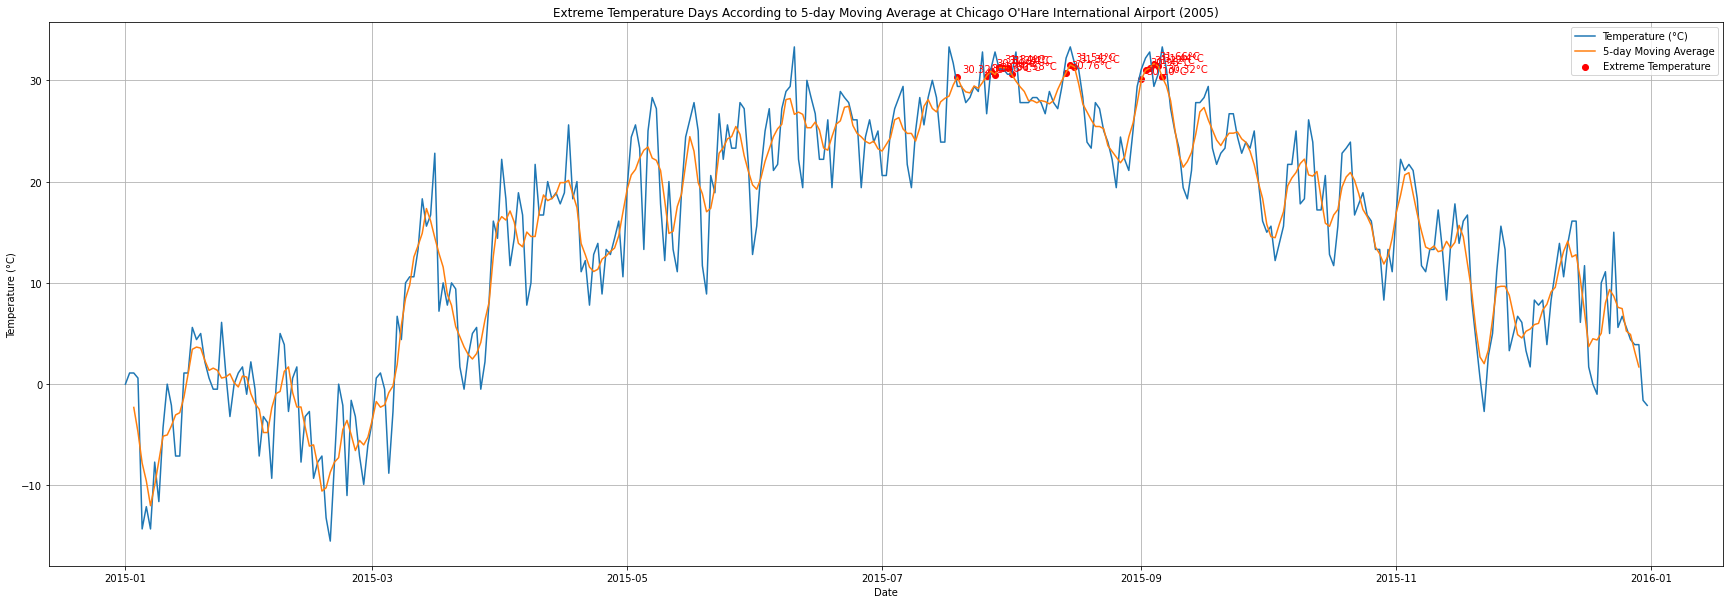

          date  moving_avg
199 2015-07-19       30.32
206 2015-07-26       30.46
207 2015-07-27       30.90
208 2015-07-28       30.56
209 2015-07-29       31.34
210 2015-07-30       31.24
211 2015-07-31       31.24
212 2015-08-01       30.58
225 2015-08-14       30.76
226 2015-08-15       31.54
227 2015-08-16       31.32
243 2015-09-01       30.10
244 2015-09-02       30.98
245 2015-09-03       31.22
246 2015-09-04       31.66
247 2015-09-05       31.44
248 2015-09-06       30.32


In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# API token for NOAA website
api_token = "ObqSaNmDtjZSNXiwFXCVhVFOnGbBYepT"

# Function to fetch weather data from NOAA API
def fetch_weather_data(api_token, station_id, year):
    base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": api_token}
    params = {
        "datasetid": "GHCND",
        "stationid": station_id,
        "startdate": f"{year}-01-01",
        "enddate": f"{year}-12-31",
        "units": "metric",
        "datatypeid": "TMAX",
        "limit": 365,  # Assuming non-leap year
    }
    response = requests.get(base_url, headers=headers, params=params)
    data = response.json()
    return data["results"]

# Chicago O'Hare International Airport weather station ID
station_id = "GHCND:USW00094846"

# Fetch temperature data for the year 2005
weather_data = fetch_weather_data(api_token, station_id, 2015)

# Create a pandas DataFrame from the fetched data
df = pd.DataFrame(weather_data)
df["date"] = pd.to_datetime(df["date"])

# Calculate the 5-day moving average temperature
df["moving_avg"] = df["value"].rolling(window=5, center=True).mean()

# Identify extreme temperature days
threshold = 30  # Set the threshold for extreme temperatures (adjust as needed)
extreme_temp_days = df[df["moving_avg"] >= threshold]

# Create DataFrame for extreme temperature days and their dates
extreme_temp_df = pd.DataFrame({
    "date": extreme_temp_days["date"],
    "moving_avg": extreme_temp_days["moving_avg"]
})

# Display temperature data in a table
print(df)

# Plot temperature data in a line chart
plt.figure(figsize=(30, 10))
plt.plot(df["date"], df["value"], label="Temperature (°C)")
plt.scatter(extreme_temp_days["date"], extreme_temp_days["value"], color="red", label="Extreme Temperature")
for date, temp in zip(extreme_temp_days["date"], extreme_temp_days["value"]):
    plt.annotate(f"{temp}°C", xy=(date, temp), xytext=(5, 5), textcoords="offset points", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Data at Chicago O'Hare International Airport (2005)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the extreme temperature days according to the 5-day moving average
plt.figure(figsize=(30, 10))
plt.plot(df["date"], df["value"], label="Temperature (°C)")
plt.plot(df["date"], df["moving_avg"], label="5-day Moving Average")
plt.scatter(extreme_temp_df["date"], extreme_temp_df["moving_avg"], color="red", label="Extreme Temperature")
for date, moving_avg in zip(extreme_temp_df["date"], extreme_temp_df["moving_avg"]):
    plt.annotate(f"{moving_avg:.2f}°C", xy=(date, moving_avg), xytext=(5, 5), textcoords="offset points", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Extreme Temperature Days According to 5-day Moving Average at Chicago O'Hare International Airport (2005)")
plt.legend()
plt.grid(True)
plt.show()

# Display the extreme temperature days and their dates in the DataFrame
print(extreme_temp_df)
#extreme_temp_df.to_excel("MA_2005.xlsx", index=False)


          date datatype            station attributes  value  moving_avg
0   2022-01-01     TMAX  GHCND:USW00094846   ,,W,2400    3.3         NaN
1   2022-01-02     TMAX  GHCND:USW00094846   ,,W,2400   -2.1         NaN
2   2022-01-03     TMAX  GHCND:USW00094846   ,,W,2400   -5.5       -0.30
3   2022-01-04     TMAX  GHCND:USW00094846   ,,W,2400    1.7       -2.82
4   2022-01-05     TMAX  GHCND:USW00094846   ,,W,2400    1.1       -4.26
..         ...      ...                ...        ...    ...         ...
360 2022-12-27     TMAX  GHCND:USW00094846   ,,W,2400   -3.8        0.60
361 2022-12-28     TMAX  GHCND:USW00094846   ,,W,2400    7.2        5.36
362 2022-12-29     TMAX  GHCND:USW00094846   ,,W,2400   15.0        7.24
363 2022-12-30     TMAX  GHCND:USW00094846   ,,W,2400   13.9         NaN
364 2022-12-31     TMAX  GHCND:USW00094846   ,,W,2400    3.9         NaN

[365 rows x 6 columns]


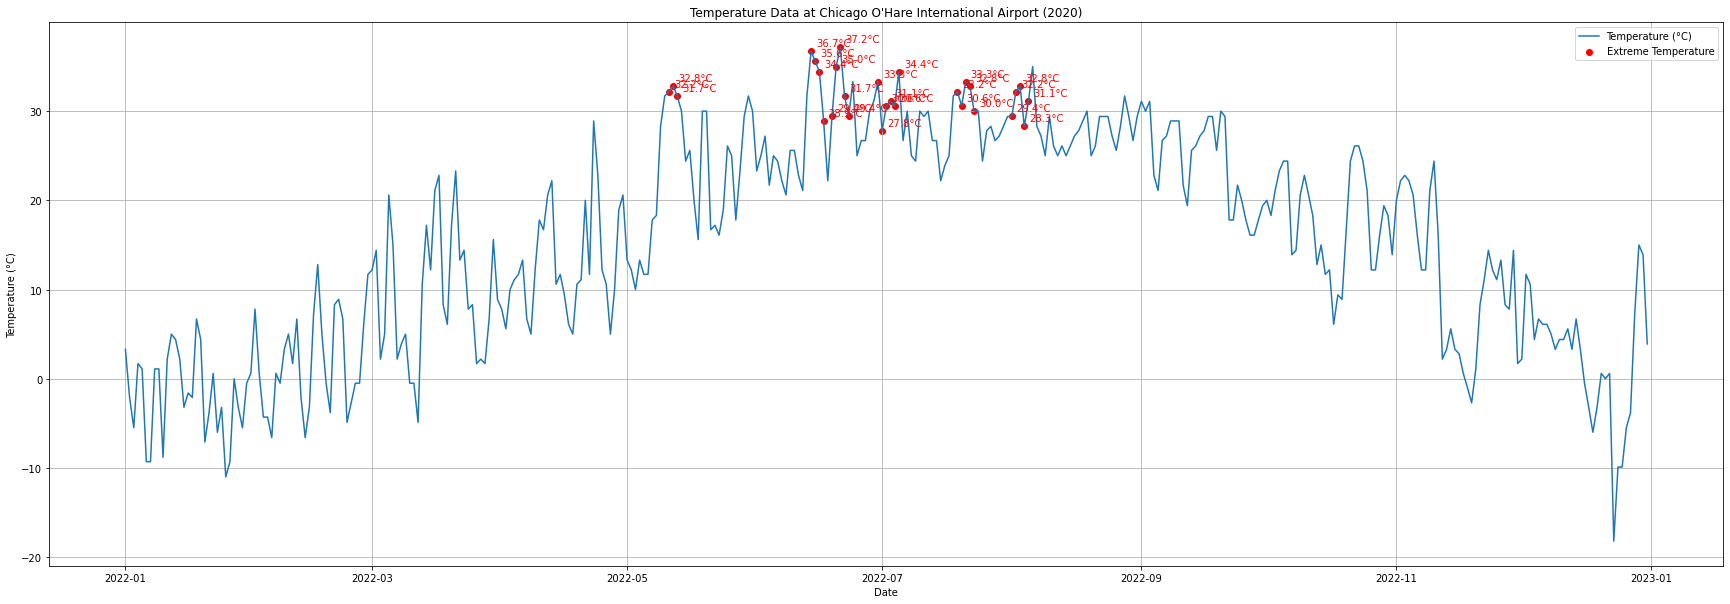

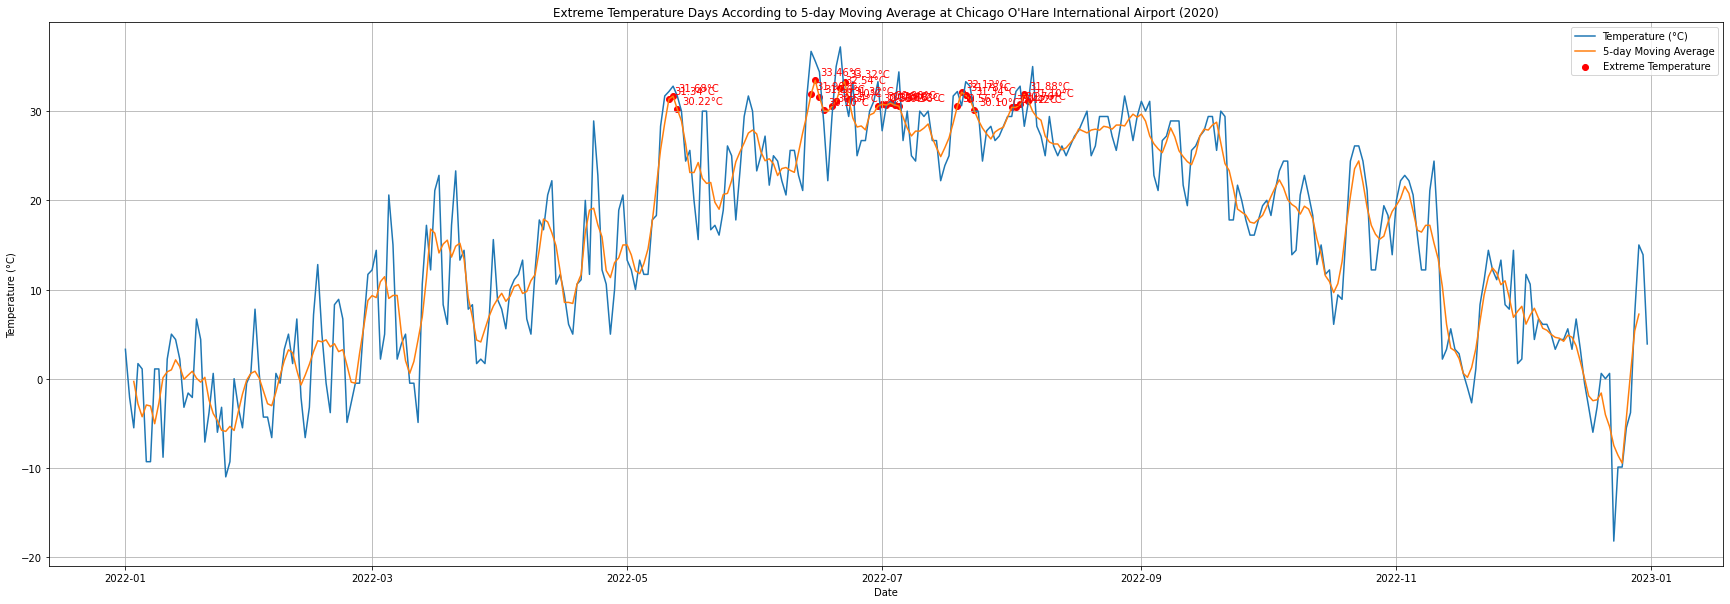

          date  moving_avg
130 2022-05-11       31.34
131 2022-05-12       31.68
132 2022-05-13       30.22
164 2022-06-14       31.90
165 2022-06-15       33.46
166 2022-06-16       31.56
167 2022-06-17       30.10
169 2022-06-19       30.54
170 2022-06-20       31.10
171 2022-06-21       32.54
172 2022-06-22       33.32
173 2022-06-23       31.32
180 2022-06-30       30.56
181 2022-07-01       30.78
182 2022-07-02       30.68
183 2022-07-03       30.90
184 2022-07-04       30.68
185 2022-07-05       30.56
199 2022-07-19       30.56
200 2022-07-20       32.12
201 2022-07-21       31.78
202 2022-07-22       31.34
203 2022-07-23       30.10
212 2022-08-01       30.42
213 2022-08-02       30.42
214 2022-08-03       30.76
215 2022-08-04       31.88
216 2022-08-05       31.10


In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# API token for NOAA website
api_token = "ObqSaNmDtjZSNXiwFXCVhVFOnGbBYepT"

# Function to fetch weather data from NOAA API
def fetch_weather_data(api_token, station_id, year):
    base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": api_token}
    params = {
        "datasetid": "GHCND",
        "stationid": station_id,
        "startdate": f"{year}-01-01",
        "enddate": f"{year}-12-31",
        "units": "metric",
        "datatypeid": "TMAX",
        "limit": 365,  # Assuming non-leap year
    }
    response = requests.get(base_url, headers=headers, params=params)
    data = response.json()
    return data["results"]

# Chicago O'Hare International Airport weather station ID
station_id = "GHCND:USW00094846"

# Fetch temperature data for the year 2000
weather_data = fetch_weather_data(api_token, station_id, 2022)

# Create a pandas DataFrame from the fetched data
df = pd.DataFrame(weather_data)
df["date"] = pd.to_datetime(df["date"])

# Calculate the 5-day moving average temperature
df["moving_avg"] = df["value"].rolling(window=5, center=True).mean()

# Identify extreme temperature days
threshold = 30  # Set the threshold for extreme temperatures (adjust as needed)
extreme_temp_days = df[df["moving_avg"] >= threshold]

# Create DataFrame for extreme temperature days and their dates
extreme_temp_df = pd.DataFrame({
    "date": extreme_temp_days["date"],
    "moving_avg": extreme_temp_days["moving_avg"]
})

# Display temperature data in a table
print(df)

# Plot temperature data in a line chart
plt.figure(figsize=(30, 10))
plt.plot(df["date"], df["value"], label="Temperature (°C)")
plt.scatter(extreme_temp_days["date"], extreme_temp_days["value"], color="red", label="Extreme Temperature")
for date, temp in zip(extreme_temp_days["date"], extreme_temp_days["value"]):
    plt.annotate(f"{temp}°C", xy=(date, temp), xytext=(5, 5), textcoords="offset points", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Data at Chicago O'Hare International Airport (2020)")
plt.legend()
plt.grid(True)
plt.savefig("temperature_plot.png")  # Save the plot as a PNG file
plt.show()

# Plot the extreme temperature days according to the 5-day moving average
plt.figure(figsize=(30, 10))
plt.plot(df["date"], df["value"], label="Temperature (°C)")
plt.plot(df["date"], df["moving_avg"], label="5-day Moving Average")
plt.scatter(extreme_temp_df["date"], extreme_temp_df["moving_avg"], color="red", label="Extreme Temperature")
for date, moving_avg in zip(extreme_temp_df["date"], extreme_temp_df["moving_avg"]):
    plt.annotate(f"{moving_avg:.2f}°C", xy=(date, moving_avg), xytext=(5, 5), textcoords="offset points", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Extreme Temperature Days According to 5-day Moving Average at Chicago O'Hare International Airport (2020)")
plt.legend()
plt.grid(True)
plt.savefig("moving_average_plot.png")  # Save the plot as a PNG file
plt.show()

# Display the extreme temperature days and their dates in the DataFrame
print(extreme_temp_df)
#extreme_temp_df.to_excel("MA_2000.xlsx", index=False)


**Example: Extracting data for the highest temperature date for the year 2005 according to NOAA data**

'earthengine' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
import datetime
import ee
import folium

# Initialize Earth Engine
ee.Initialize()

# Define a function to get image information as a dictionary
def get_image_info(image):
    image_id = image.get('system:index').getInfo()
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    band_names = image.bandNames().getInfo()
    cloud_cover = image.get('CLOUD_COVER').getInfo()
    
    return {
        'Image ID': image_id,
        'Capture Date': date,
        'Band Names': band_names,
        'Cloud Cover (%)': cloud_cover,
        'Image': image  # Store the Earth Engine image object
    }

# Define the bounding box coordinates
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Convert the bounding box to an Earth Engine Geometry object
geometry = ee.Geometry.Rectangle(bounding_box)

# Define the date range for your search
date_start = datetime.datetime(2015, 9, 1)
date_end = datetime.datetime(2015, 9, 30)

# Define the cloud cover threshold (adjust as needed)
cloud_cover_threshold = 30

# Filter the Landsat collection based on the bounding box, date range, and cloud cover threshold
landsat_collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .merge(ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")) \
    .merge(ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")) \
    .filterBounds(geometry) \
    .filterDate(date_start, date_end) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_cover_threshold)

# Get the image information and store it in a list of dictionaries
image_info_list = []
num_images = landsat_collection.size().getInfo()
image_list = landsat_collection.toList(num_images)

for i in range(num_images):
    image = ee.Image(image_list.get(i))
    image_info = get_image_info(image)
    image_info_list.append(image_info)

# Get the number of images in the collection
num_images = landsat_collection.size().getInfo()

# Print the number of images
print(f"Number of Landsat images found: {num_images}")

# Create a pandas DataFrame from the list of dictionaries
import pandas as pd
df = pd.DataFrame(image_info_list)

# Display the DataFrame
print(df)

# Create a color palette for different image IDs
import random
import matplotlib.colors as colors
image_ids = df['Image ID'].unique()
num_colors = len(image_ids)
color_palette = [colors.to_hex([random.random(), random.random(), random.random()]) for _ in range(num_colors)]

# Visualize the captured images on the map
# Get the center of the bounding box for map centering
center = [sum(bounding_box[1::2])/2, sum(bounding_box[::2])/2]

# Create a folium map
m = folium.Map(location=center, zoom_start=10)

# Add image footprints to the map with corresponding colors
for image_info in image_info_list:
    image = image_info['Image']
    date = image_info['Capture Date']
    image_id = image_info['Image ID']
    color = color_palette[list(image_ids).index(image_id)]
    footprint = image.geometry()
    
    # Create a GeoJSON FeatureCollection with the footprint and assigned color
    feature_collection = ee.FeatureCollection([ee.Feature(footprint, {'style': {'color': color}})])
    
    # Add the FeatureCollection to the map
    folium.GeoJson(
        data=feature_collection.getInfo(),
        name=f"{image_id} - {date}",
        style_function=lambda x: {'color': x['properties']['style']['color'], 'fillOpacity': 0.5, 'weight': 1}
    ).add_to(m)

# Create a legend
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: auto; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Legend</b> <br>"""

for idx, image_id in enumerate(image_ids):
    color = color_palette[idx]
    legend_html += f'<i style="background:{color}; width: 12px; height: 12px; display: inline-block;"></i>&nbsp;{image_id}<br>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(m)


Number of Landsat images found: 5
                   Image ID Capture Date  \
0  1_1_LC08_022031_20150903   2015-09-03   
1  1_1_LC08_023030_20150926   2015-09-26   
2  1_1_LC08_023031_20150926   2015-09-26   
3    2_LE07_023030_20150902   2015-09-02   
4    2_LE07_023031_20150902   2015-09-02   

                                          Band Names  Cloud Cover (%)  \
0  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...            24.64   
1  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...            25.43   
2  [B1, B2, B3, B4, B5, B6, B7, B10, B11, sr_aero...             3.06   
3  [B1, B2, B3, B4, B5, B6, B7, sr_atmos_opacity,...             5.00   
4  [B1, B2, B3, B4, B5, B6, B7, sr_atmos_opacity,...            18.00   

                                               Image  
0  ee.Image({\n  "functionInvocationValue": {\n  ...  
1  ee.Image({\n  "functionInvocationValue": {\n  ...  
2  ee.Image({\n  "functionInvocationValue": {\n  ...  
3  ee.Image({\n  "functionInvocationValue"

# 4. Extracting MODIS LST 

In [9]:
import ee
import datetime
import folium

# Initialize Earth Engine
ee.Initialize()

# Function to extract MODIS Land Surface Temperature (LST) data
def get_modis_lst(start_date, end_date, bbox):
    # Convert date strings to ee.Date objects
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # Create a bounding box geometry
    bounding_box = ee.Geometry.Rectangle(bbox)

    # Filter MODIS LST collection based on date and area of interest
    modis_lst_collection = ee.ImageCollection('MODIS/006/MOD11A1') \
        .filterDate(start_date, end_date) \
        .filterBounds(bounding_box)

    # Select LST band and convert it to Celsius
    modis_lst_celsius = modis_lst_collection.select('LST_Day_1km') \
        .map(lambda image: image.multiply(0.02).subtract(273.15))  # Conversion formula

    return modis_lst_celsius

# Define the date range and area of interest (bounding box)
start_date = '2015-01-01'
end_date = '2015-01-31'
# Define the bounding box coordinates (lon, lat, lon, lat)
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Get MODIS LST data
modis_lst_celsius = get_modis_lst(start_date, end_date, bounding_box)

# Get the number of images in the collection
num_images = modis_lst_celsius.size().getInfo()
print('Number of images in the collection:', num_images)

# Create a folium map centered on the bounding box area
map_center = [sum(bounding_box[1::2])/2, sum(bounding_box[0::2])/2]
map_zoom = 7
map = folium.Map(location=map_center, zoom_start=map_zoom)

# Function to add image and legend to the map
def add_image_to_map(image):
    # Get the URL for the image visualization
    url = image.getThumbUrl({
        'min': -10,
        'max': 40,
        'region': region_for_vis.toGeoJSONString()  # Convert the region to GeoJSON string
    })

    # Add the image as a TileLayer to the map
    folium.TileLayer(
        tiles=url,
        attr='MODIS LST',
        name='MODIS LST',
        overlay=True,
        control=True,
    ).add_to(map)

    # Create a legend for the image
    legend_html = '''
         <div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; background:white; padding: 10px; border: 1px solid grey; border-radius: 5px;">
           <p><b>MODIS Land Surface Temperature (LST)</b></p>
           <p><b>Capturing Date:</b> {}</p>
           <p><b>Number of Images:</b> {}</p>
           <img src="{}" alt="legend" width="150px" height="200px">
         </div>
    '''.format(start_date, num_images, url)

    map.get_root().html.add_child(folium.Element(legend_html))

# Specify a region for visualization (same as bounding box)
region_for_vis = ee.Geometry.Rectangle(bounding_box)

# Loop through all images and add them to the map
modis_lst_list = modis_lst_celsius.toList(num_images)
for i in range(num_images):
    image = ee.Image(modis_lst_list.get(i))
    add_image_to_map(image)

# Display the map
map


Number of images in the collection: 30


In [ ]:
import ee
import datetime

# Initialize Earth Engine
ee.Initialize()

# Function to extract MODIS Land Surface Temperature (LST) data
def get_modis_lst(start_date, end_date, bbox):
    # Convert date strings to ee.Date objects
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # Create a bounding box geometry
    bounding_box = ee.Geometry.Rectangle(bbox)

    # Filter MODIS LST collection based on date and area of interest
    modis_lst_collection = ee.ImageCollection('MODIS/006/MOD11A1') \
        .filterDate(start_date, end_date) \
        .filterBounds(bounding_box)

    # Select LST band and convert it to Celsius
    modis_lst_celsius = modis_lst_collection.select('LST_Day_1km') \
        .map(lambda image: image.multiply(0.02).subtract(273.15))  # Conversion formula

    return modis_lst_celsius

# Define the date range and area of interest (bounding box)
start_date = '2015-01-01'
end_date = '2015-01-31'
# Define the bounding box coordinates (lon, lat, lon, lat)
bounding_box = [-88.425659, 41.553400, -87.338012, 42.319564]

# Get MODIS LST data
modis_lst_celsius = get_modis_lst(start_date, end_date, bounding_box)

# Limit data to a single image for visualization
single_image = modis_lst_celsius.first()

# Specify a region for visualization (same as bounding box)
region_for_vis = ee.Geometry.Rectangle(bounding_box)

# Get the URL for the image visualization
url = single_image.getThumbUrl({
    'min': -10,
    'max': 40,
    'region': region_for_vis.toGeoJSONString()  # Convert the region to GeoJSON string
})
print("Image URL for visualization:", url)

# Example of how to visualize the image on the map
from IPython.display import Image
Image(url=url)


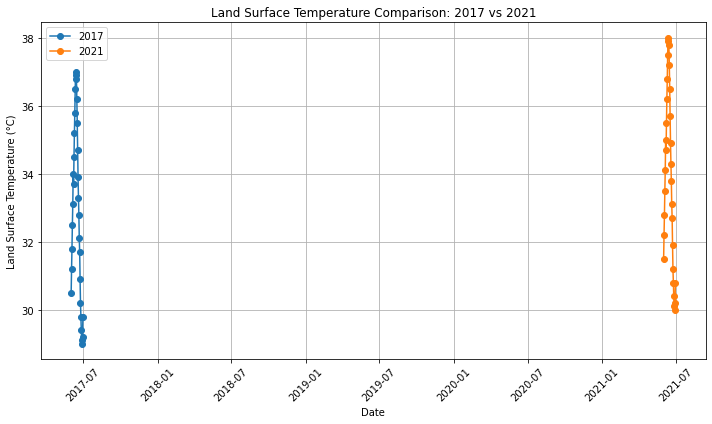

Average temperature change from 2017 to 2021: 1.00°C


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
data_2017 = {
    'Date': pd.date_range(start='2017-06-01', periods=30, freq='D'),
    'Land_Surface_Temperature_C': [30.5, 31.2, 31.8, 32.5, 33.1, 34.0, 33.7, 34.5, 35.2, 35.8, 36.5, 37.0, 36.9, 36.8, 36.2, 35.5, 34.7, 33.9, 33.3, 32.8, 32.1, 31.7, 30.9, 30.2, 29.8, 29.4, 29.1, 29.0, 29.2, 29.8]
}

data_2021 = {
    'Date': pd.date_range(start='2021-06-01', periods=30, freq='D'),
    'Land_Surface_Temperature_C': [31.5, 32.2, 32.8, 33.5, 34.1, 35.0, 34.7, 35.5, 36.2, 36.8, 37.5, 38.0, 37.9, 37.8, 37.2, 36.5, 35.7, 34.9, 34.3, 33.8, 33.1, 32.7, 31.9, 31.2, 30.8, 30.4, 30.1, 30.0, 30.2, 30.8]
}

df_2017 = pd.DataFrame(data_2017)
df_2021 = pd.DataFrame(data_2021)

# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(df_2017['Date'], df_2017['Land_Surface_Temperature_C'], label='2017', marker='o')
plt.plot(df_2021['Date'], df_2021['Land_Surface_Temperature_C'], label='2021', marker='o')
plt.xlabel('Date')
plt.ylabel('Land Surface Temperature (°C)')
plt.title('Land Surface Temperature Comparison: 2017 vs 2021')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identifying changes in temperatures
temperature_changes = df_2021['Land_Surface_Temperature_C'] - df_2017['Land_Surface_Temperature_C']
average_change = temperature_changes.mean()
print("Average temperature change from 2017 to 2021: {:.2f}°C".format(average_change))


In [12]:
import datetime
import ee
import folium
import pandas as pd
import random
import matplotlib.colors as colors

# Authenticate to Earth Engine using your credentials
# Make sure you have your authentication credentials set up properly
# ee.Authenticate()  # Uncomment and run this line if you need to authenticate

# Initialize Earth Engine
ee.Initialize()

# Rest of your imports...

# Define a function to handle authentication errors
def handle_ee_exception(func):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except ee.EEException as e:
            print("Earth Engine Exception:", e)
            print("Please check your authentication credentials and API usage.")
    return wrapper

# Define a function to get image information as a dictionary
@handle_ee_exception
def get_image_info(image):
    # Rest of your function...

# Define a function to filter Landsat collection
@handle_ee_exception
def filter_landsat_collection(geometry, date_start, date_end, cloud_cover_threshold):
    # Rest of your function...

# Rest of your code...

# Display the map
m.save("landsat_image_map.html")


IndentationError: expected an indented block (<ipython-input-12-7397b4e1a640>, line 33)